In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import os

import pprint
pp = pprint.PrettyPrinter()


In [2]:
def prep_dmv_sample(raw_dataframe, save=False, filename="clean_test_data.csv"):
    # Data prep from sample downloaded from web site database

    original_length = len(raw_dataframe)
    print(f"Original length of sample data is {original_length}")

    # Drop data with Result.isna(). These events also have TotalScore=0, IPAddress.isna().
    # - Show them using: df[df["Result"].isna()]
    # - rest_index() is needed after the rows are dropped

    df = raw_dataframe.dropna(axis=0, subset=["Result"]).reset_index(drop=True)

    dropped_nan = original_length - len(df)
    print(f"{dropped_nan} tests with Result, IPAddress, TotalScore = NaN dropped")

    # Add column, ip, with the port number from the reported ip address
    df["ip"] = df.IPAddress.apply(lambda x: x.split(":")[0])

    # Add column, duration, for the TotalTimeSpent in minutes
    df["duration"] = df.TotalTimeSpent/60    

    # Add column, duration, for the TotalTimeSpent in minutes
    df["duration"] = df.TotalTimeSpent/60

    # Some events have more than 1 ip address
    df["multiple_ip"] = df.ip.apply( lambda x: len(x.split(","))>1)

    # Remove the extra ip address from tests with more than 1 ip address
    df.loc[:,"ip"] = df.ip.apply(lambda x: x.split(",")[0])
    print(f'Extra ip address dropped in {len(df[df["multiple_ip"]])} tests')
    
    # Make a copy of the cleaned data
    if save:
        df.to_csv("clean_test_data.csv", index=False)
    return df

In [3]:
sample_filename = "OPT11022021-11042021.csv"

# Read the sample data downloaded from the DMV testing web site
test_sample = pd.read_csv(sample_filename)

# Work with a shallow copy
raw_dataframe = test_sample.copy()

In [4]:
df = prep_dmv_sample(raw_dataframe, save=True)

Original length of sample data is 4561
110 tests with Result, IPAddress, TotalScore = NaN dropped
Extra ip address dropped in 36 tests


In [5]:
df


,TestAttemptId,UserName,ExamineeId,TestId,LocaleId,TestLocationId,KioskId,KioskAssignDate,TestRegistrationDate,DownloadDate,...,LicDocTypeCode,LicClassCode,LicExpireDate,DriverPrivilegeCode,DriverStatusCode,ParentClientId,IPAddress.1,ip,duration,multiple_ip
0,5237674,NaN,18316,5182,1033,705,NaN,NaN,11/2/2021 0:39,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,35.221.42.251:60044,142.255.122.114,22.983333,False
1,5237672,NaN,20016,5181,1033,705,NaN,NaN,11/2/2021 0:36,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,35.221.42.251:59940,172.58.230.193,16.016667,False
2,5245169,NaN,30685,5181,1033,705,NaN,NaN,11/3/2021 17:32,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,34.150.174.152:34042,72.68.212.63,15.500000,False
3,5240992,NaN,33299,5181,1033,705,NaN,NaN,11/2/2021 17:31,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,34.86.154.96:50706,172.100.125.174,22.400000,False
4,5240851,NaN,39527,5181,1033,705,NaN,NaN,11/2/2021 16:56,NaN,...,NaN,D,00:00.0,1.0,NaN,NaN,34.86.212.218:41130,24.228.215.103,46.433333,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446,5252222,NaN,2998971,5181,2117,705,NaN,NaN,11/5/2021 12:23,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,34.86.212.218:60186,104.162.23.135,23.033333,False
4447,5252237,NaN,2998977,5181,1033,705,NaN,NaN,11/5/2021 12:24,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,34.86.212.218:60284,24.184.24.136,20.500000,False
4448,5252273,NaN,2998990,5181,1033,705,NaN,NaN,11/5/2021 12:32,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,34.150.174.152:35308,208.91.121.188,13.950000,False
4449,5252301,NaN,2999001,5181,1033,705,NaN,NaN,11/5/2021 12:34,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,34.150.174.152:35424,69.125.106.24,10.966667,False


In [6]:
def plt_duration(df, vlines=12., cum=False):
    """Chart the test duration histogram for passing result"""
    # Start 10 x 8 figure and point to axes object
    fig = plt.figure(figsize=(15,8))
    ax = plt.axes()

    # Use hist for each passing result
    plt.hist(df[df.Result == "P"]["duration"], bins=100, density=False, \
             histtype="step", cumulative=cum, linewidth=2, label='Pass')
    plt.hist(df[df.Result == "F"]["duration"], bins=100, density=False, \
             histtype="step", cumulative=cum, linewidth=2, label='Fail')
    plt.hist(df[df.Result == "None"]["duration"], bins=100, density=False, \
             histtype="step", cumulative=cum, linewidth=2, label='None')
    
    # Draw a vertical line at the first peak of the passing histogram
    ax.axvline(x=vlines, color="red", linewidth=4, ls=":", label=f"{vlines} min")
    
    plt.title('DMV - Test Duration by Test Result')
    plt.xlabel('Frequency')
    plt.ylabel('Duration (min)')
    plt.legend()   # Uses labels assigned in plt.hist

    plt.show

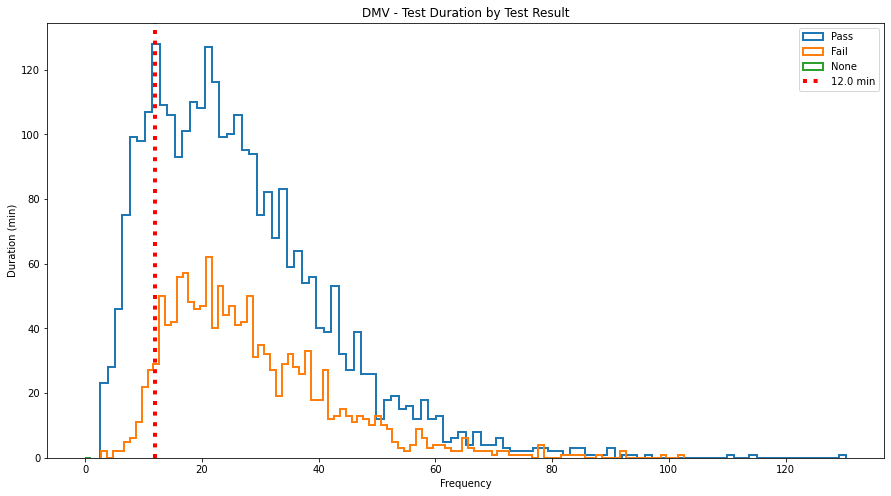

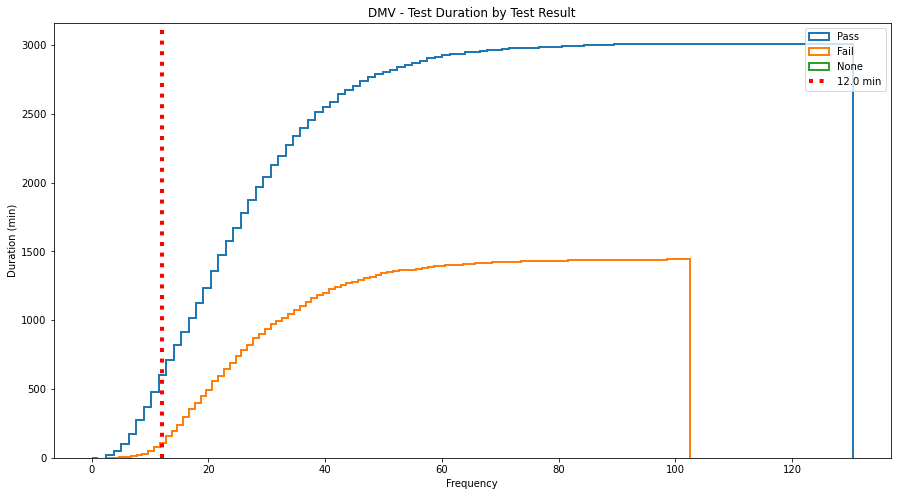

In [7]:
plt_duration(df)
plt_duration(df, cum=True)


In [8]:
# Find index 

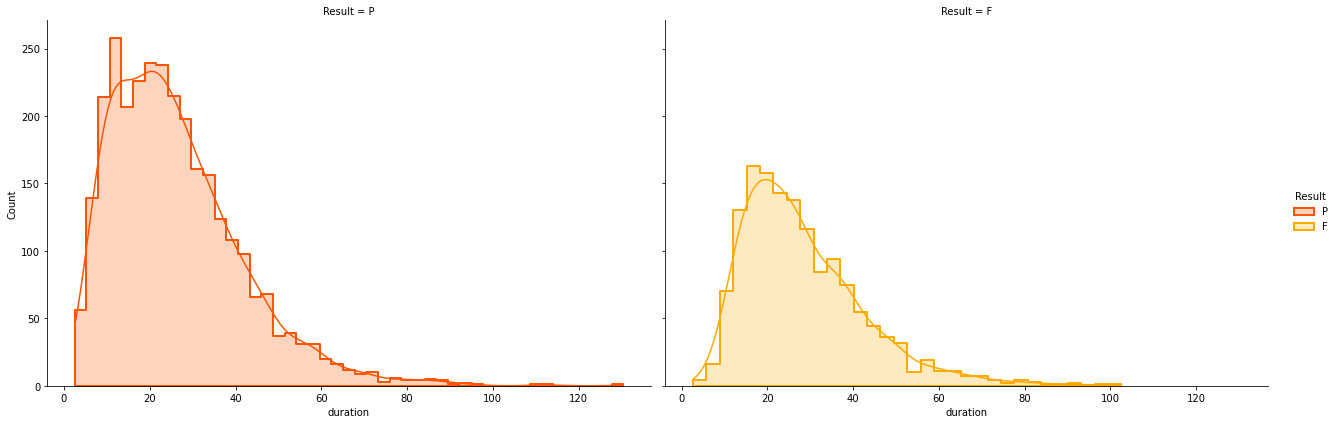

In [9]:
# Show same data using a different plotting package, displot. 
# displot can alse calculate the kde (kernel density estimate)
def displot_duration(df):
    g1 = sns.displot(data=df, x='duration', stat='count', kind='hist', cumulative=False, kde=True, col='Result', \
                 hue='Result', palette='autumn', aspect=1.5, element='step', height=6, \
                 fill=True, linewidth=2, common_bins=False, common_norm=False, \
                 facet_kws={'sharex':True, 'sharey':True}
                 )
    return g1

displot_duration(df)


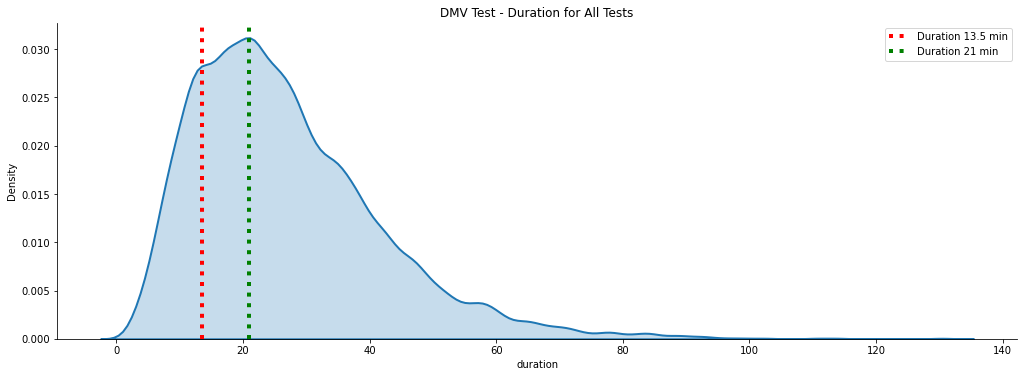

In [10]:
def displot_kde_duration_all(df, peak1=12, peak2=20, bw_adjust=0.6):
    
#     plt.figure(figsize=(12,6))
    # sns.displot(data=df, x='TotalTimeSpent', stat='count', kind='kde', cumulative=False, kde=True, bw_adjust=.25,\
    g = sns.displot(data=df, x='duration', kind='kde', cumulative=False, bw_adjust=bw_adjust,\
#                      hue='Result', \
                     palette='prism', aspect=1.5, height=6, \
                     fill=True, linewidth=2,  \
                     facet_kws={'sharex':True, 'sharey':True}
                     )

    g.fig.set_figwidth(15)
    g.fig.set_figheight(5)

    plt.axvline(x=peak1, color="red", linewidth=4, ls=":", label=f"Duration {peak1} min")
    plt.axvline(x=peak2, color="green", linewidth=4, ls=":", label=f"Duration {peak2} min")
    plt.title("DMV Test - Duration for All Tests")
    plt.legend()
    return g


displot_kde_duration_all(df, peak1=13.5, peak2=21, bw_adjust=.6)

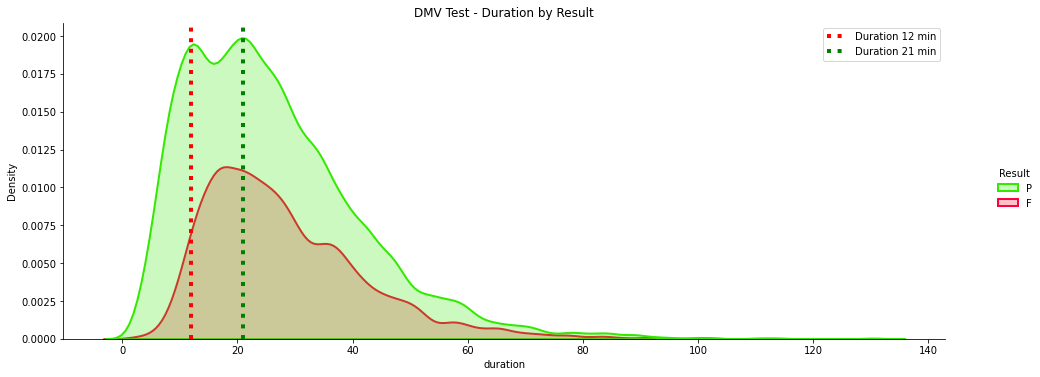

In [11]:
def displot_kde_duration(df, peak1=12, peak2=20, bw_adjust=0.6):
    
#     plt.figure(figsize=(12,6))
    # sns.displot(data=df, x='TotalTimeSpent', stat='count', kind='kde', cumulative=False, kde=True, bw_adjust=.25,\
    g = sns.displot(data=df, x='duration', kind='kde', cumulative=False, bw_adjust=bw_adjust,\
                     hue='Result', palette='prism', aspect=1.5, height=6, \
                     fill=True, linewidth=2,  \
                     facet_kws={'sharex':True, 'sharey':True}
                     )

    g.fig.set_figwidth(15)
    g.fig.set_figheight(5)

    plt.axvline(x=peak1, color="red", linewidth=4, ls=":", label=f"Duration {peak1} min")
    plt.axvline(x=peak2, color="green", linewidth=4, ls=":", label=f"Duration {peak2} min")
    plt.title("DMV Test - Duration by Result")
    plt.legend()
    return g

g = displot_kde_duration(df, peak2=21)

The passed tests are bimodal with an early peak around 12 min. DMV officials think that the test should take more than 5 minutes. In fact, very few of the failing tests take less than 5 minutes. 

The dstribution of failed tests is unimodal with a slight broadening.

In [12]:
def displot_kde_passed_partitions(df, quartiles, bw_adjust=0.6):
    
#     plt.figure(figsize=(12,6))
    # sns.displot(data=df, x='TotalTimeSpent', stat='count', kind='kde', cumulative=False, kde=True, bw_adjust=.25,\
    g = sns.displot(data=df, x='duration', kind='kde', cumulative=False, bw_adjust=bw_adjust,\
                     hue='Result', palette='prism', aspect=1.5, height=6, \
                     fill=True, linewidth=2,  \
                     facet_kws={'sharex':True, 'sharey':True}
                     )

    g.fig.set_figwidth(15)
    g.fig.set_figheight(5)

    plt.vlines(quartiles, 0, 0.03, linewidth=2, ls=":")
#     plt.axvline(x=peak2, color="green", linewidth=4, ls=":", label=f"Duration {peak2} min")
    plt.title("DMV Test - Duration for Passed Tests - by Result - Shows Quartiles")
    plt.legend(labels=["Passed", "25%", "50%", "75%"])
    return g

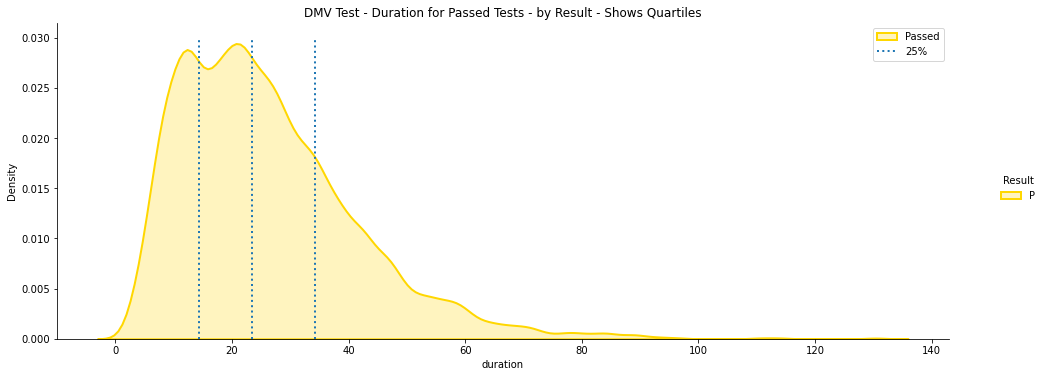

In [13]:
quartiles={ x:df[df.Result==x]["duration"].describe() for x in ["P","F"] }
g = displot_kde_passed_partitions(df[df.Result=="P"], list(quartiles["P"][["25%", "50%", "75%"]]) ) 

In [14]:
# Add column suspect when TotalTimeSpent <= 5m (or 6.5m)
fastest = 12
passed = pd.DataFrame(df[df.Result=="P"])


In [15]:
passed["suspect"] = passed.duration.apply(lambda x: "suspect" if x <= fastest else "ok")

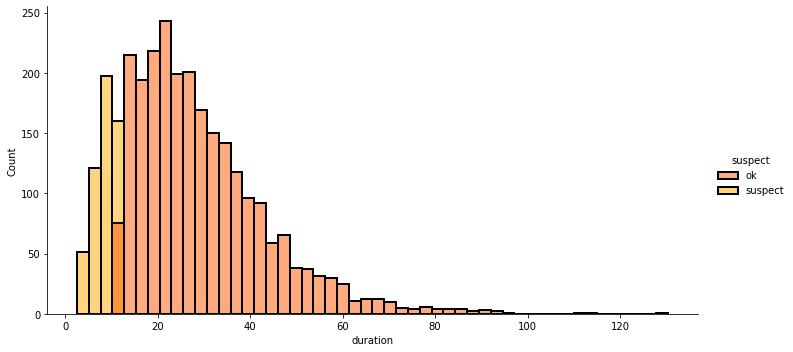

In [16]:
def displot_suspect(df, bw_adjust=0.9):
    
    
    g1 = sns.displot(data=df, x='duration', hue='suspect', \
                     kind='hist', bins=50, \
                     stat="count", \
                     palette='autumn', aspect=2, \
                     fill=True, linewidth=2,  \
                     facet_kws={'sharex':True, 'sharey':True}
                     )
#     g1.fig.set_figwidth=(15)
#     g1.fig.set_figheight=(5)
#     plt.axvline(x=fastest, color="red", linewidth=4, ls=":", label="5 min")

displot_suspect(passed)

In [17]:
def displot_2suspect(df, base="TotalQuestionsCorrect", compare="duration", suspect=True, fastest=15, bw_adjust=0.9):
    # Scatter plot showing the total questions that are answered correctly
    # by the total time to answer
    
    df.loc["suspect"] = df.duration.apply(lambda x: "suspect" if x <= fastest else "ok")
    
    case = "suspect" if suspect else "ok"
    
    sns.displot(data=df[df.suspect==case], x=compare, y='duration', \
                     kind="kde", \
                     palette='autumn', aspect=1, \
                     bins=10, \
                     )
    plt.title(f"{compare} vs Duration of Passed Tests {' <= ' if case=='suspect' else ' > '}{fastest} min ")


/home/bkrawchuk/anaconda3/envs/dmv_test/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'bins'
  cset = contour_func(
/home/bkrawchuk/anaconda3/envs/dmv_test/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'bins'
  cset = contour_func(


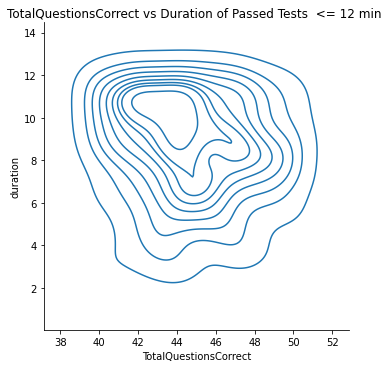

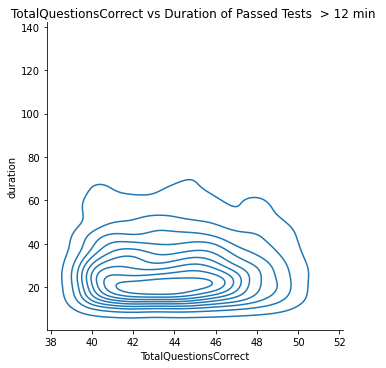

In [18]:
# 
# displot_2suspect(passed[passed.suspect=="ok"])
# displot_2suspect(passed[passed.suspect=="suspect"])

displot_2suspect(passed, compare="TotalQuestionsCorrect", suspect=True, fastest=12)
displot_2suspect(passed, compare="TotalQuestionsCorrect", suspect=False, fastest=12)

For test taking more than 12 minutes there's a uniform number of correctly answered questions bewtween 41 an 47. For tests that take less than 12 min, it is not so uniform. There are a high numer of excellent score >48 for test that take 7-9 minutes. There's more very high scoring tests at 7-8 minutes. The number of correct answers appears to be trending to uniformity above 10 minutes.

In [19]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
def displot_xy(df, 
               base="TotalQuestionsCorrect", 
               compare="duration", 
               suspect=True, 
               fastest=12, 
               bw_adjust=0.9, 
               nminor = 1,
               bins=10):
    
    # Scatter plot showing the total questions that are answered correctly
    # by the total time to answer
    
    df["suspect"] = df.duration.apply(lambda x: "suspect" if x <= fastest else "not suspected")
    
    case = "suspect" if suspect else "not suspected"
    g = sns.displot(data=df[df.suspect==case], x=base, y=compare, \
#                      kind="kde", \
                     palette='autumn', aspect=1, \
                     bins=bins, \
                     cbar=True, \
                     )
    g.ax.yaxis.set_minor_locator(AutoMinorLocator(nminor + 1))
    plt.title(f"{base} vs {compare} {' <= ' if case=='suspected' else ' > '}{fastest} min ")

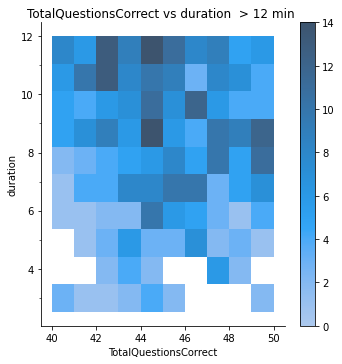

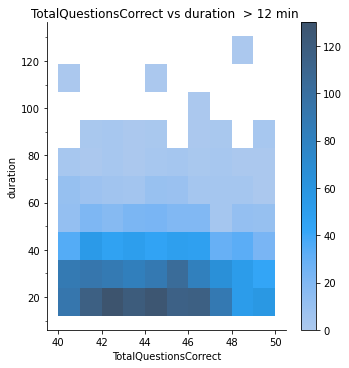

In [20]:
displot_xy(passed)
displot_xy(passed, suspect=False)


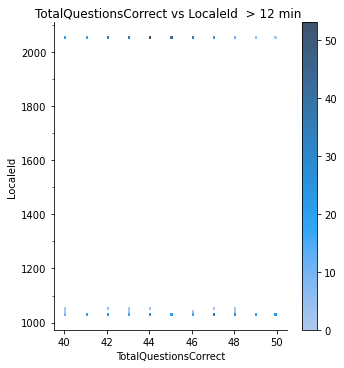

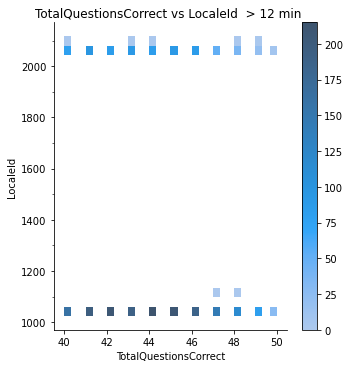

In [21]:
displot_xy(passed, compare="LocaleId", bins=100)
displot_xy(passed, suspect=False, compare="LocaleId", bins=30)

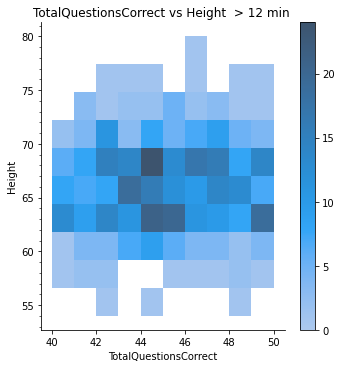

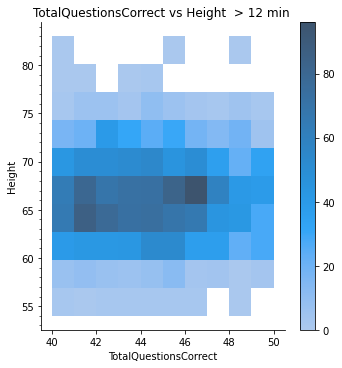

In [22]:
displot_xy(passed, base="TotalQuestionsCorrect", compare="Height", bins=10, nminor=4)
displot_xy(passed, suspect=False, base="TotalQuestionsCorrect", compare="Height", bins=10, nminor=4)

In [23]:
def ips_that_are_duplicated(df):
    d = {}
    for ip in df.ip:
        if ip in d:
            d[ip] += 1
        else:
            d[ip] = 1
    return { k:v for k,v in d.items() if v > 1 }

len(ips_that_are_duplicated(df))


645

In [24]:
duplicated = df[df.ip.duplicated(keep=False)]\
[["ip", "TestStartDateTime", "Result", "TotalQuestionsCorrect", "duration", "Email", "Token"]]
duplicated.sort_values(["ip", "TestStartDateTime"])

,ip,TestStartDateTime,Result,TotalQuestionsCorrect,duration,Email,Token
3791,100.12.122.32,11/4/2021 14:41,F,37,14.950000,andyc1115@gmail.com,KKEQRDW
3792,100.12.122.32,11/4/2021 21:02,P,41,13.766667,andyc1115@gmail.com,KKEQRDW
1818,100.12.197.98,11/2/2021 21:34,P,46,16.783333,daniela250803@gmail.com,ADYGCX
3854,100.12.197.98,11/4/2021 15:28,P,44,12.450000,d8602075@gmail.com,XZ8OHIX
3945,100.12.205.241,11/4/2021 17:17,F,34,13.333333,joegagliano1721@gmail.com,N3WQP4P
...,...,...,...,...,...,...,...
3558,98.15.40.143,11/3/2021 23:52,P,41,38.816667,betonaxi83@gmail.com,JINWH
4253,98.15.40.143,11/4/2021 22:23,P,49,22.166667,Felicianosua@gmail.com,LPGNZON
1321,98.15.51.183,11/2/2021 15:46,P,45,7.883333,carlos-diaz1990@outlook.com,CFP62A6
2331,98.15.51.183,11/3/2021 16:59,P,43,7.900000,catherine-argote92@outlook.com,73FNRD6


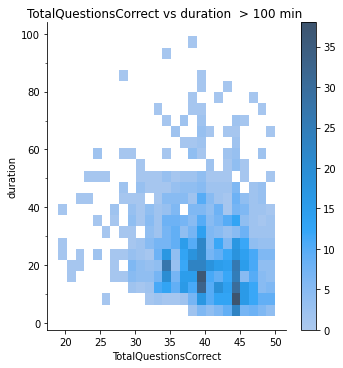

In [25]:

# displot_xy(df[df.ip.duplicated(keep=False)].reset_index(), \
displot_xy(duplicated,
           base="TotalQuestionsCorrect", 
           compare="duration", 
           suspect=True, 
           fastest=100, 
           bw_adjust=0.9, 
           bins=25)

In [26]:
# pd.options.display.min_rows=0
pd.options.display.max_rows=50


In [27]:
# len(duplicated.duplicated(keep='first'))
# len(df[df.ip.duplicated(keep='True')])
duplicated.sort_values(["ip","TestStartDateTime"])

,ip,TestStartDateTime,Result,TotalQuestionsCorrect,duration,Email,Token,suspect
3791,100.12.122.32,11/4/2021 14:41,F,37,14.950000,andyc1115@gmail.com,KKEQRDW,suspect
3792,100.12.122.32,11/4/2021 21:02,P,41,13.766667,andyc1115@gmail.com,KKEQRDW,suspect
1818,100.12.197.98,11/2/2021 21:34,P,46,16.783333,daniela250803@gmail.com,ADYGCX,suspect
3854,100.12.197.98,11/4/2021 15:28,P,44,12.450000,d8602075@gmail.com,XZ8OHIX,suspect
3945,100.12.205.241,11/4/2021 17:17,F,34,13.333333,joegagliano1721@gmail.com,N3WQP4P,suspect
...,...,...,...,...,...,...,...,...
3558,98.15.40.143,11/3/2021 23:52,P,41,38.816667,betonaxi83@gmail.com,JINWH,suspect
4253,98.15.40.143,11/4/2021 22:23,P,49,22.166667,Felicianosua@gmail.com,LPGNZON,suspect
1321,98.15.51.183,11/2/2021 15:46,P,45,7.883333,carlos-diaz1990@outlook.com,CFP62A6,suspect
2331,98.15.51.183,11/3/2021 16:59,P,43,7.900000,catherine-argote92@outlook.com,73FNRD6,suspect


In [31]:
import mywhois

# Investigate number_correct vs risk fro dmv test sample
risk = mywhois.Risk("mywhois", readonly=True)

# Read the sample data downloaded from the DMV testing web site
clean = pd.read_csv("clean_test_data.csv")
v = clean[["TestStartDateTime", "TotalScore", "Result", "TotalQuestionsCorrect", "ip", "duration"]]

def f(x):
    r = risk.find(x)
    if r:
        return r["score"]
    return -1
def g(x):
    r = risk.find(x)
    if r:
        return r["risk"]
    return "Unknown"
# np.nan
    
#     return risk.find(x)

v["score"] = v["ip"].apply(f)
v["risk"] = v["ip"].apply(g)


/tmp/ipykernel_8371/3961764747.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v["score"] = v["ip"].apply(f)
/tmp/ipykernel_8371/3961764747.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v["risk"] = v["ip"].apply(g)


In [32]:
v


,TestStartDateTime,TotalScore,Result,TotalQuestionsCorrect,ip,duration,score,risk
0,11/2/2021 0:41,40,P,40,142.255.122.114,22.983333,16,low
1,11/2/2021 0:37,38,F,38,172.58.230.193,16.016667,0,low
2,11/3/2021 17:33,28,F,28,72.68.212.63,15.500000,12,low
3,11/2/2021 17:34,49,P,49,172.100.125.174,22.400000,8,low
4,11/2/2021 16:57,47,P,47,24.228.215.103,46.433333,16,low
...,...,...,...,...,...,...,...,...
4446,11/5/2021 12:29,43,P,43,104.162.23.135,23.033333,16,low
4447,11/5/2021 12:25,34,F,34,24.184.24.136,20.500000,16,low
4448,11/5/2021 12:33,40,P,40,208.91.121.188,13.950000,0,low
4449,11/5/2021 12:35,40,P,40,69.125.106.24,10.966667,16,low


/tmp/ipykernel_8371/3037929108.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["suspect"] = df.duration.apply(lambda x: "suspect" if x <= fastest else "not suspected")


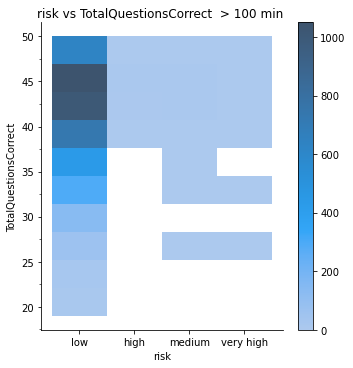

In [39]:
# displot_xy(df[df.ip.duplicated(keep=False)].reset_index(), \
displot_xy(v,
           base="risk", 
           compare="TotalQuestionsCorrect", 
           suspect=True, 
           fastest=100, 
           bw_adjust=0.9, 
           bins=10)

In [ ]:
duplicated[duplicated.Token.duplicated(keep=F)]